# EDA for HMDA in Orange County, NC, 2018, 2019


In [1]:
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler

In [44]:
def merge_data():
    '''
    merge 2018, 19 data and write them to a new csv file
    '''
    Orange_2018 = pd.read_csv("./data_raw/county_37135_2018.csv")
    Orange_2019 = pd.read_csv("./data_raw/county_37135_2019.csv")
    Orange = pd.concat([Orange_2018, Orange_2019])
    Orange.to_csv("./data_cleaned/county_37135.csv", index=False)

# merge_data()

In [45]:
# Orange = pd.read_csv("./data_cleaned/county_37135.csv")


In [56]:
Orange.columns[Orange.isnull().mean() < 0.1]

Index([&#39;activity_year&#39;, &#39;lei&#39;, &#39;derived_msa-md&#39;, &#39;state_code&#39;, &#39;county_code&#39;,
       &#39;census_tract&#39;, &#39;conforming_loan_limit&#39;, &#39;derived_loan_product_type&#39;,
       &#39;derived_dwelling_category&#39;, &#39;derived_ethnicity&#39;, &#39;derived_race&#39;,
       &#39;derived_sex&#39;, &#39;action_taken&#39;, &#39;purchaser_type&#39;, &#39;preapproval&#39;,
       &#39;loan_type&#39;, &#39;loan_purpose&#39;, &#39;lien_status&#39;, &#39;reverse_mortgage&#39;,
       &#39;open-end_line_of_credit&#39;, &#39;business_or_commercial_purpose&#39;,
       &#39;loan_amount&#39;, &#39;hoepa_status&#39;, &#39;loan_term&#39;, &#39;negative_amortization&#39;,
       &#39;interest_only_payment&#39;, &#39;balloon_payment&#39;,
       &#39;other_nonamortizing_features&#39;, &#39;construction_method&#39;, &#39;occupancy_type&#39;,
       &#39;manufactured_home_secured_property_type&#39;,
       &#39;manufactured_home_land_property_interest&#39;

In [60]:
def drop_na_columns():
    merge_data()
    Orange = pd.read_csv("./data_cleaned/county_37135.csv")
    Orange.replace(r'\s+',np.nan,regex=True).replace('',np.nan).replace('NA', np.nan)
    # drop all columns that has too much (> 20%) missing data
    Orange = Orange[Orange.columns[Orange.isnull().mean() < 0.1]].iloc[:, : ]
    Orange.to_csv("./data_cleaned/county_37135.csv", index=False)

# drop_na_columns()

In [62]:
def extract_essential_columns():
    drop_na_columns()
    Orange = pd.read_csv("./data_cleaned/county_37135.csv")
    cols = [c for c in Orange.columns if not (c.startswith("applicant_ethnicity") or c.startswith("co-applicant_ethnicity") or c.endswith("observed"))]
    # add purchaser_type shoule be 0 in 18,19 case as those are the individuals
    # These are the variables that I think are important for fairness analysis
    essential_list = ["activity_year", "county_code", "derived_loan_product_type", "derived_dwelling_category", "derived_ethnicity", "derived_race", "derived_sex", "action_taken", "purchaser_type", "loan_purpose", "loan_amount", "loan_term", "income", "applicant_age", "denial_reason-1"]
    Orange = Orange.loc[:, essential_list]
    Orange.to_csv("./data_cleaned/county_37135.csv", index=False)

extract_essential_columns()


(array([7.867e+03, 2.680e+02, 1.581e+03, 0.000e+00, 1.547e+03, 4.880e+02,
        0.000e+00, 1.339e+03, 2.000e+00, 1.000e+00]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 &lt;a list of 10 Patch objects&gt;)

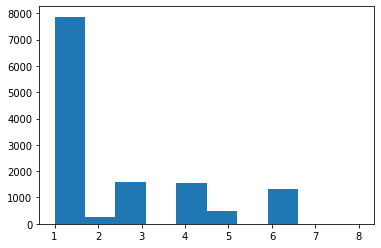

In [2]:
Orange = pd.read_csv("./data_cleaned/county_37135.csv")
plt.hist(Orange["action_taken"])

## EDA

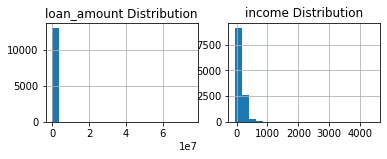

In [3]:
# plot 4 numerical hist
numerical_cols = ['loan_amount', 'income']
n_rows, n_cols = 2, 2
fig=plt.figure()
for i, var_name in enumerate(numerical_cols):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    Orange[var_name].hist(bins=20, ax=ax)
    ax.set_title(var_name+" Distribution")
# fig.tight_layout()  # Improves appearance a bit.
plt.show()

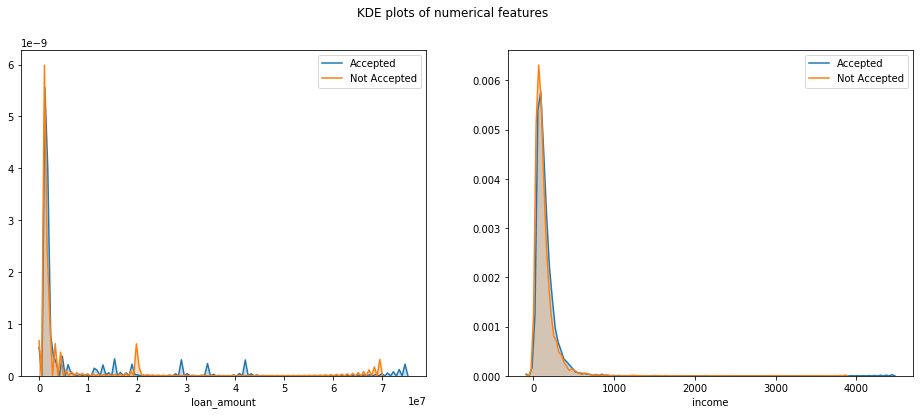

In [4]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (16,6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
fig.suptitle("KDE plots of numerical features")

for ax, col in zip(axes.flatten(), numerical_cols) :
    sns.kdeplot(Orange[Orange["action_taken"] == 1][col], shade="True", label="Accepted", ax = ax)
    sns.kdeplot(Orange[Orange["action_taken"] != 1][col], shade="True", label="Not Accepted", ax = ax)
    ax.set_xlabel(col)

plt.savefig("./plots/KDE plots of numerical features.png")

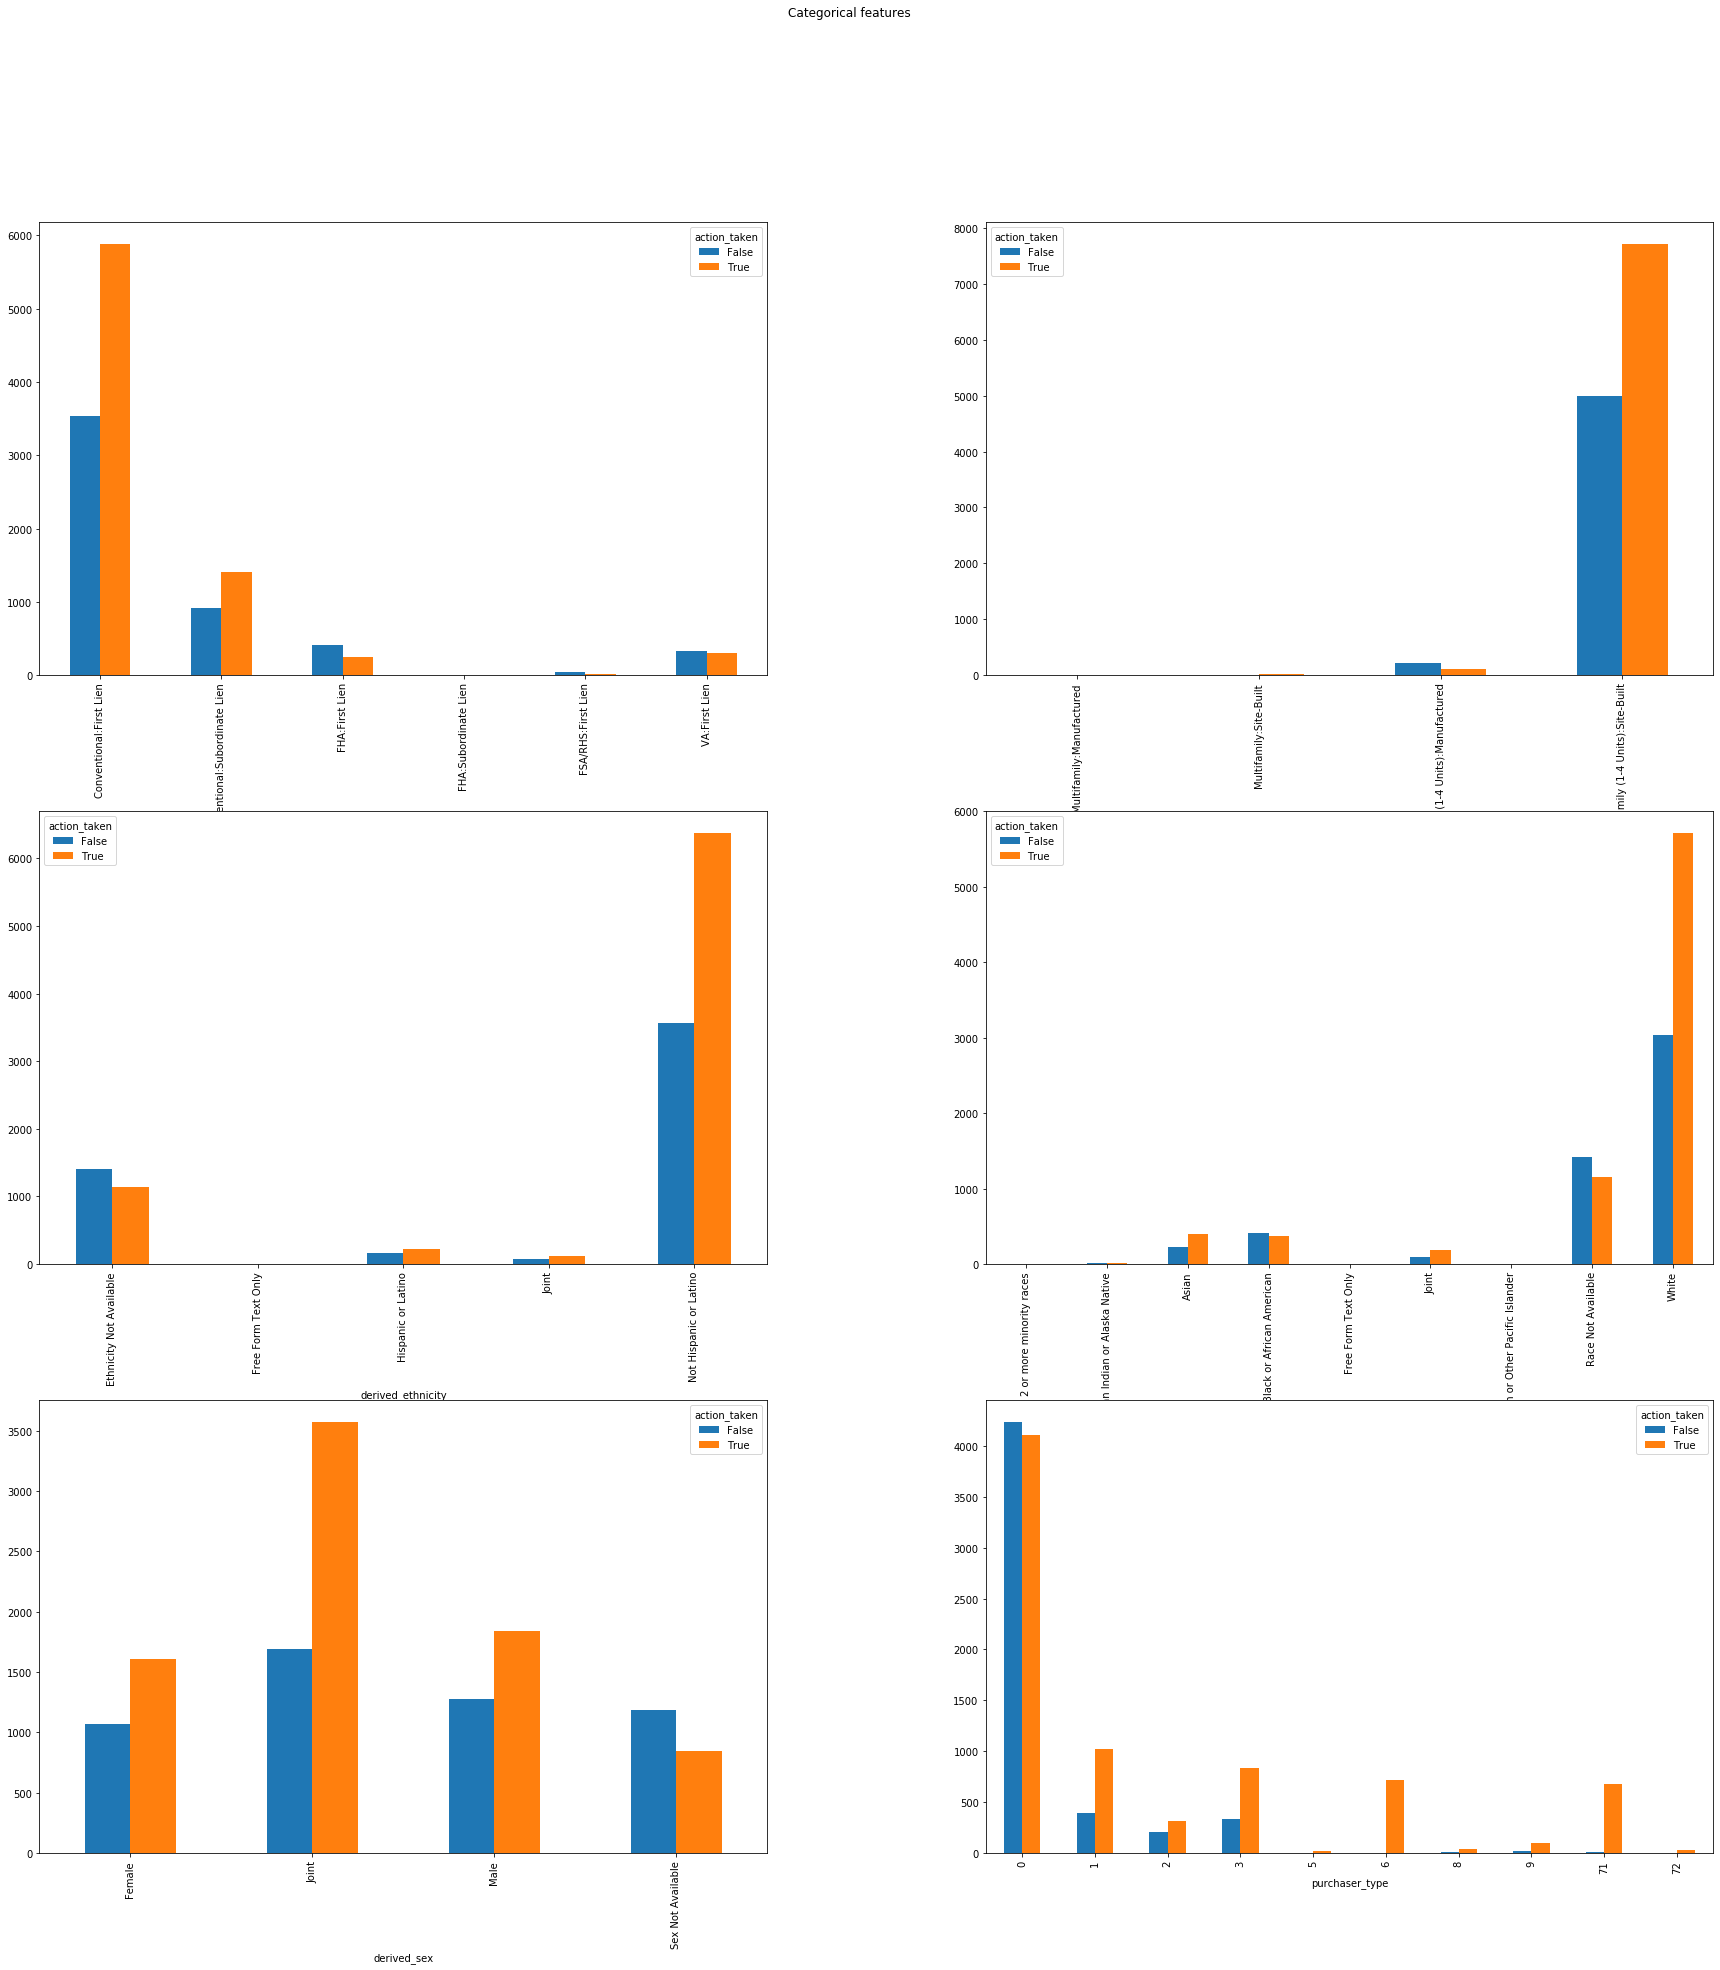

In [9]:
cat_cols= [ "derived_loan_product_type", "derived_dwelling_category", "derived_ethnicity", "derived_race", "derived_sex", "purchaser_type", "loan_purpose",]
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (30, 30))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle("Categorical features")

for ax, col in zip(axes.flatten(), cat_cols):
    pd.crosstab(Orange[col], Orange["action_taken"]==1).plot(kind="bar", ax = ax)
    ax.set_xlabel(col)

plt.savefig("./plots/Categorical features.png")